#**1.Downloading train and test file from github repository**

In [ ]:
import pandas as pd
import numpy as np
import random as rnd
 
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import requests
download_url = "https://raw.githubusercontent.com/an-Nash/taitanic/master/train.csv"
target_csv_path = "train.csv"
response = requests.get(download_url)
print(response.raise_for_status())    # Check that the request was successful
with open(target_csv_path, "wb") as f:
    f.write(response.content)
print("Download ready.")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


None
Download ready.


**Loading train file by pandas**

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
train_df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [ ]:
download_url = "https://raw.githubusercontent.com/an-Nash/taitanic/master/test.csv"
target_csv_path = "test.csv"
response = requests.get(download_url)
print(response.raise_for_status())    # Check that the request was successful
with open(target_csv_path, "wb") as f:
    f.write(response.content)

None


#**Initial exploration of data**

**There are total 12 attributes and 5 of them are object type. Here we can see some attribute (age,cabin,embarked) are missing data as there are total 891 data for each attribute.**

In [ ]:
train_df.info()

NameError: ignored

In [ ]:
test_df = pd.read_csv("test.csv")
test_df.head(4)

NameError: ignored

**Here we can see there are 11 attribute excluding survived attribute. And some of them are missing data. We have to fix this data later.**

In [ ]:
test_df.info()

**Initiial visulaization of data**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

In [ ]:
train_df.describe(include=['O'])

In [ ]:
train_df.describe()

#**Correlation of attributes**

*We may want to complete Age feature as it is definitely correlated to survival.

*We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

*Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.

*Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.

*PassengerId may be dropped from training dataset as it does not contribute to survival.

*Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.


In [ ]:
#To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. 
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [ ]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [ ]:
# train_df[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

* We should consider Age in our model training.

* Complete the Age feature for null values.

* We should band age groups.

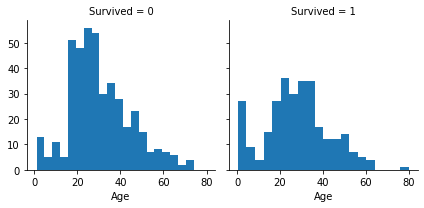

In [ ]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

* Pclass=3 had most passengers, however most did not 
survive.

* Infant passengers in Pclass=2 and Pclass=3 mostly survived.

* Most passengers in Pclass=1 survived.Confirms our classifying assumption

* Consider Pclass for model training.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


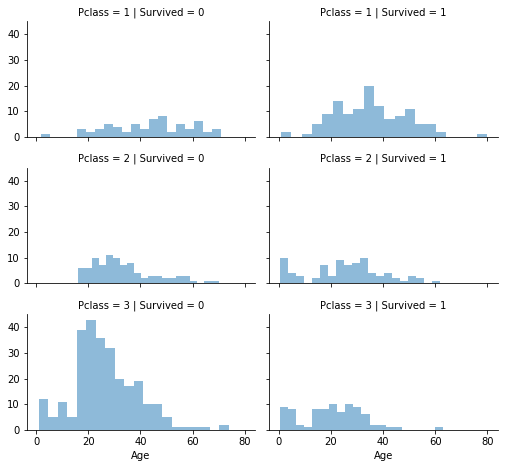

In [ ]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

* Female passengers had much better survival rate than males. Confirms classifying.
* Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived
* Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports.
* Add Sex feature to model training.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


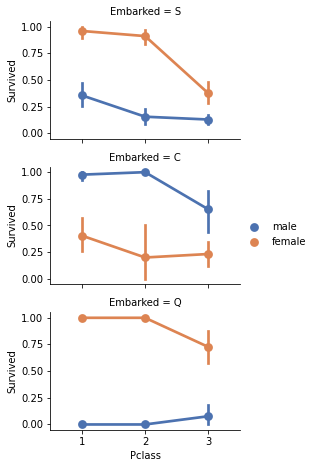

In [ ]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

* Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
* Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

* Consider banding Fare feature.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


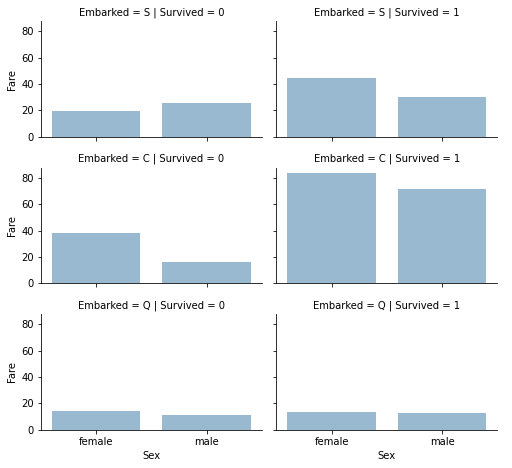

In [ ]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

**Droping and adding features**

By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin and Ticket features as it doesn't have any correlation with surviving.  

In [ ]:
print("Before", train_df.shape, test_df.shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [ ]:
#We can replace many titles with a more common name or classify them as Rare
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [ ]:
#We can convert the categorical titles to ordinal.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [ ]:
#Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

**Converting categorical features**

In [ ]:
#Now we can convert features which contain strings to numerical values
#start by converting Sex feature to a new feature called Gender where female=1 and male=0.
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


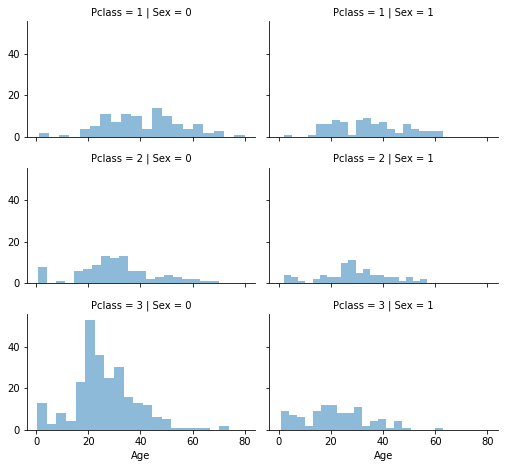

In [ ]:
#Filling missing data of Age attribute
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

accurate way of guessing missing values is to use other correlated features in this problem. so in our case we note correlation among Age, Gender, and Pclass

In [ ]:
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [ ]:
#Now it's fillup the missing value of Age
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Title     891 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 62.8+ KB


In [ ]:
#we have to create Age bands and determine correlations with Survived.
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [ ]:
#Replace age based on these bands
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [ ]:
#Remove ageband
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


**Feature creating by existing features**

In [ ]:
#We can create a new feature for FamilySize which combines Parch and SibSp. 
#This will enable us to drop Parch and SibSp from our datasets.
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [ ]:
#We can create another feature called IsAlone
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [ ]:
#Drop parch,Sibsp and Familimysize 
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [ ]:
#Adding new feature
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [ ]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [ ]:
#Converting categorical feature to numeric
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [ ]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [ ]:
#FareBand
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [ ]:
#Convert Fare feature to ordinal value
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [ ]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


#**Model selection**

In [ ]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

**Logistic regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

**KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

In [ ]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Decision Tree'],
    'Score': [acc_knn, acc_log, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,86.76
0,KNN,84.74
1,Logistic Regression,80.36


#**Cross validation for the model**

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
#Cross validation for logistic regression
from sklearn.model_selection import cross_val_score
log_scores = cross_val_score(logreg, X_train ,Y_train, scoring="neg_mean_squared_error", cv=10)
log_rmse_scores = np.sqrt(-log_scores)
display_scores(log_rmse_scores)

Scores: [0.42163702 0.43704832 0.48575205 0.36719404 0.42399915 0.44971901
 0.48575205 0.44971901 0.42399915 0.47404546]
Mean: 0.4418865278657219
Standard deviation: 0.034143222780117354


In [ ]:
from sklearn.metrics import mean_squared_error

hs = logreg.predict(X_train)
lin_mse = mean_squared_error(Y_train, hs)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.4431800195652587

In [ ]:
#KNN cross validation
knn_scores = cross_val_score(knn, X_train ,Y_train, scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-log_scores)
display_scores(knn_rmse_scores)

Scores: [0.42163702 0.43704832 0.48575205 0.36719404 0.42399915 0.44971901
 0.48575205 0.44971901 0.42399915 0.47404546]
Mean: 0.4418865278657219
Standard deviation: 0.034143222780117354


In [ ]:
#Decision tree cross validation
dec_tree_scores = cross_val_score(decision_tree, X_train ,Y_train, scoring="neg_mean_squared_error", cv=10)
dec_rmse_scores = np.sqrt(-dec_tree_scores)
display_scores(dec_rmse_scores)

Scores: [0.52704628 0.42399915 0.52999894 0.42399915 0.38218767 0.48575205
 0.41053541 0.43704832 0.39661489 0.42399915]
Mean: 0.44411810213090674
Standard deviation: 0.049467175955070275


#**Grid search for tuining the model**

In [ ]:
#We are applying grid search on decision tree
#Let's see if we can get better performance
from sklearn.model_selection import GridSearchCV
# param_grid = [
# {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
# {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
# ]
# decision_tree = DecisionTreeClassifier()
# grid_search = GridSearchCV(decision_tree, param_grid, cv=5,
# scoring='neg_mean_squared_error',
# return_train_score=True)
# grid_search.fit(X_train, Y_train)
# accuracy_score = make_scorer(accuracy_score,greater_is_better = True)
dtc = DecisionTreeClassifier()
depth = np.arange(1,30)
leaves = [1,2,4,5,10,20,30,40,80,100]
param_grid =[{'max_depth':depth,
             'min_samples_leaf':leaves}]
grid_search = GridSearchCV(estimator = dtc,param_grid = param_grid,
                           scoring='neg_mean_squared_error',cv=10)
grid_search = grid_search.fit(X_train,Y_train)

In [ ]:
grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 1}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 2}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 4}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 5}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 10}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 20}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 30}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 40}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 80}
0.46659978118859363 {'max_depth': 1, 'min_samples_leaf': 100}
0.45929164371074926 {'max_depth': 2, 'min_samples_leaf': 1}
0.45929164371074926 {'max_depth': 2, 'min_samples_leaf': 2}
0.45929164371074926 {'max_depth': 2, 'min_samples_leaf': 4}
0.45929164371074926 {'max_depth': 2, 'min_samples_leaf': 5}
0.45929164371074926 {'max_depth': 2, 'min_samples_leaf': 10}
0.45929164371074926 {'max_depth': 2, 'min_samples_leaf': 20}
0.45929164371074926 {'max_depth

We are getting some optimize value for our grid search

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('/content/drive/My Drive/AI/submission.csv', index=False)